#  Effects of Loan Status, Credit Grade/Prosper Rating on Borrower Rate 
## by Shuo You

## Investigation Overview

In this project, I will explore the effects of loan status, credit grade/Prosper Rating on borrower rate for Prosper loans.

## Dataset Overview

The original Prosper loan dataset contains 113,937 loan records and 81 variables. For this analysis, I'm interested in comparing completed loans with defaulted loans, so a subset of data were selected. After data wrangling, my main dataset has 49640 loan records with two loan status groups: 'Completed' and 'Defaulted'. As Credit Grade and Prosper Rating features were used for loans originated before July 2009 and after July 2009 respectively, further subsetting of the main dataset was conducted.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# Set figure legend font size.
plt.rc('legend',**{'fontsize':12})

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

# Subset the dataframe to include only "Completed", "Chargedoff", "Defaulted" loans, save in new variable 'df_sub'. 
df_sub = df.query('LoanStatus in ["Completed", "Chargedoff", "Defaulted"]').copy()

# Replace 'Chargedoff' loans with 'Defaulted' status.
df_sub.LoanStatus = df_sub.LoanStatus.replace('Chargedoff', 'Defaulted')

In [3]:
# Convert the 'ListingCreationDate' column into datetime format.
df_sub['ListingCreationDate'] = pd.to_datetime(df_sub.ListingCreationDate)

# Convert the 'Term' column into object datatype.
df_sub['Term'] = df_sub['Term'].astype(str)

# Convert 'LoanStatus', 'CreditGrade', 'ProsperRating (Alpha)', 'Term', 'IncomeRange' into ordered categorical types.

ordinal_var_dict = {'LoanStatus': ['Completed', 'Defaulted'],
                    'CreditGrade': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
                    'ProsperRating (Alpha)': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
                    'Term': ['12', '36', '60'],
                    'IncomeRange': ['Not displayed', 'Not employed', '$0', '$1-24,999', 
                                    '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df_sub[var] = df_sub[var].astype(ordered_var)

In [4]:
# Data wrangling on 'df_sub' dataset.

# Select records with not null 'DebtToIncomeRatio'.
mask = df_sub.DebtToIncomeRatio.notna()
df_sub = df_sub.loc[mask, :]

# Keep records with 'IncomeVerifiable' not equal to 'False'.  
mask2 = df_sub.IncomeVerifiable != False
df_sub = df_sub.loc[mask2, :]

# Drop records with 'MonthlyLoanPayment' below and equal to $16.66
df_sub = df_sub[df_sub.MonthlyLoanPayment > 16.66]

In [5]:
# Further subset 'df_sub' dataset into two new dataframes: 'df_old_loans' for loans originated before July 2009,
# and 'df_new_loans' which contains all loans originated after July 2009. 
df_old_loans = df_sub[df_sub['ListingCreationDate'] < '2009-07-01'].copy()
df_new_loans = df_sub[df_sub['ListingCreationDate'] > '2009-07-01'].copy()

In [6]:
# Data wrangling on 'df_old_loans' dataset.

# Select all records with not null 'CreditGrade'.
mask3 = df_old_loans.CreditGrade.notnull()
df_old_loans = df_old_loans.loc[mask3, :]

# Drop columns: 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 
# 'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore' 
col_to_drop = ['EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 
               'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore' ]

df_old_loans.drop(col_to_drop, axis=1, inplace=True)

In [7]:
# Data wrangling on 'df_new_loans' dataset.

# Drop the 'CreditGrade' column. 
df_new_loans.drop('CreditGrade', axis=1, inplace=True)

## Distribution of Borrower Rate

Most of the Borrower Rate falls between 0.05 and 0.35. The distribution of Borrower Rate is roughly unimodel with several spikes seen at certain rates.

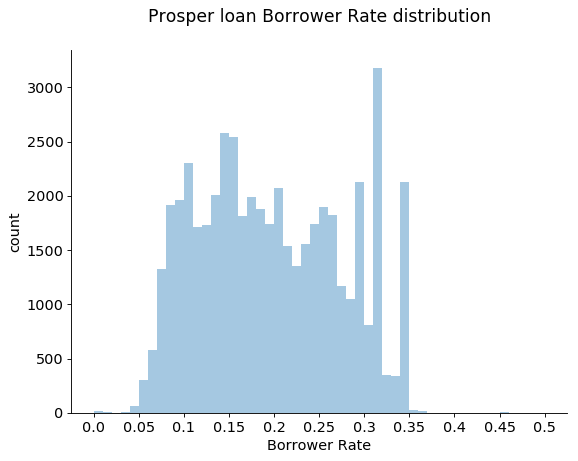

In [8]:
# Since 'BorrowerRate' is a numeric variable, I will plot its distribution using a histogram.
plt.figure(figsize=(8, 6), dpi=80)
bin_edges = np.arange(0, df_sub.BorrowerRate.max()+0.01, 0.01)
ax = sb.distplot(df_sub.BorrowerRate, kde = False, bins= bin_edges)

# Set figure title, y= 1.06 adds a little space between the title and the chart.
plt.title('Prosper loan Borrower Rate distribution', fontsize= 15.5, y= 1.06)

# Only kept the bottom & left axes line. 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Define the x & y ticks/labels
rate_ticks = np.arange(0, df_sub.BorrowerRate.max()+ 0.05, 0.05)
plt.xticks(rate_ticks, rate_ticks, fontsize= 13)
plt.xlabel('Borrower Rate', fontsize= 13)
plt.yticks(fontsize= 13)
plt.ylabel('count', fontsize= 13);

## Borrow Rate distribution between different Loan Status groups

The Defaulted loan group generally have higher Borrower Rates compared to the Completed loan group.
The median borrower rate for completed loans (around 0.17) is similar to the 25th Percentile borrower rate of defaulted loans, indicating the cost of borrowing is generally higher for the defaulted loan group.

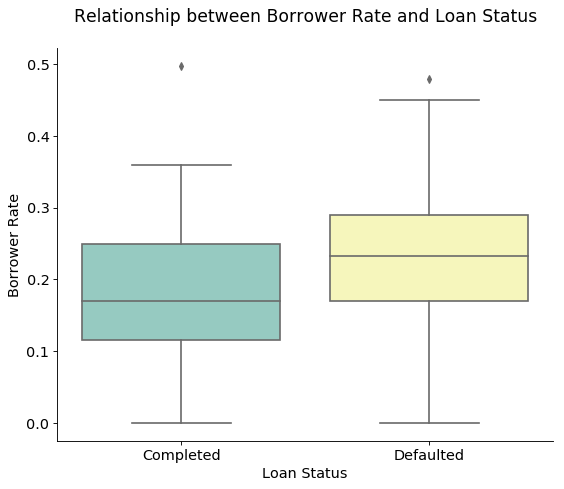

In [9]:
# Create a boxplot to present the relationship between 'LoanStatus' and 'BorrowerRate'.
plt.figure(figsize=(8, 6.5), dpi=80)
 
ax = sb.boxplot(data = df_sub, x = 'LoanStatus', y = 'BorrowerRate', palette="Set3")

# Set figure title, y= 1.05 adds a little space between the title and the chart.
plt.title('Relationship between Borrower Rate and Loan Status', fontsize= 15.5, y= 1.05)

# Only kept the bottom & left axes line. 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Define the x & y ticks/labels
plt.xticks(fontsize= 13)
plt.xlabel('Loan Status', fontsize= 13)
plt.yticks(fontsize= 13)
plt.ylabel('Borrower Rate', fontsize= 13);

## Credit Grade vs Borrower Rate

As Credit Grade increases in quality (from 'HR' to 'AA'), the median Borrower Rate gradually decreases from around 0.28 to 0.10. <br> 
This suggests higher credit grade borrowers tend to have lower Borrower Rate.  

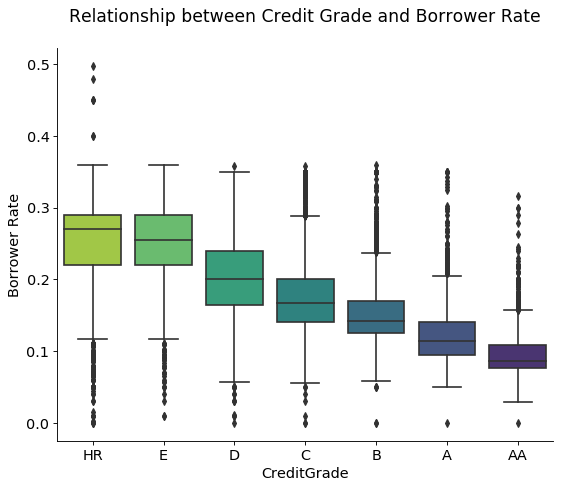

In [10]:
# Create a boxplot to present the relationship between 'CreditGrade' and 'BorrowerRate'.
plt.figure(figsize=(8, 6.5), dpi=80)
 
ax = sb.boxplot(data = df_old_loans, x = 'CreditGrade', y = 'BorrowerRate', palette="viridis_r")

# Set figure title, y= 1.05 adds a little space between the title and the chart.
plt.title('Relationship between Credit Grade and Borrower Rate', fontsize= 15.5, y= 1.05)

# Only kept the bottom & left axes line. 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Define the x & y ticks/labels
plt.xticks(fontsize= 13)
plt.xlabel('CreditGrade', fontsize= 13)
plt.yticks(fontsize= 13)
plt.ylabel('Borrower Rate', fontsize= 13);

## Prosper Rating vs Borrower Rate

Median Borrower Rate also gradually decreases (from 0.32 to 0.08) as Prosper Rating increases (from 'HR' to 'AA').<br> 
This indicates higher Prosper Rating borrowers also tend to have lower Borrower Rate.  

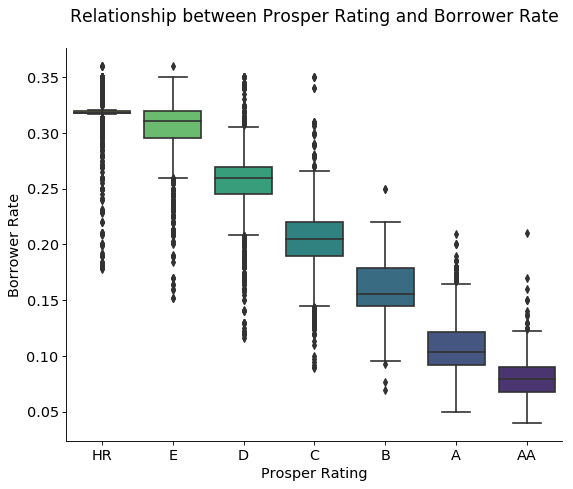

In [11]:
# Create a boxplot to present the relationship between 'ProsperRating (Alpha)' and 'BorrowerRate'.
plt.figure(figsize=(8, 6.5), dpi=80)
 
ax = sb.boxplot(data = df_new_loans, x = 'ProsperRating (Alpha)', y = 'BorrowerRate', palette="viridis_r")

# Set figure title, y= 1.05 adds a little space between the title and the chart.
plt.title('Relationship between Prosper Rating and Borrower Rate', fontsize= 15.5, y= 1.05)

# Only kept the bottom & left axes line. 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Define the x & y ticks/labels
plt.xticks(fontsize= 13)
plt.xlabel('Prosper Rating', fontsize= 13)
plt.yticks(fontsize= 13)
plt.ylabel('Borrower Rate', fontsize= 13);

## Effects of Loan Status, Credit Grade on Borrower Rate

For both the completed and defaulted loans, lower Credit Grade 'HR' and 'E' loans have the highest Mean Borrower Rate. <br>
As Credit Grade increases in quality (from 'HR' to 'AA'), the Mean Borrower Rate tend to be lower (except for 'HR' vs 'E' loans). <br> 
Interestingly, the defaulted loans have higher Mean Borrower Rate in every Credit Grade compared to the completed loans. 

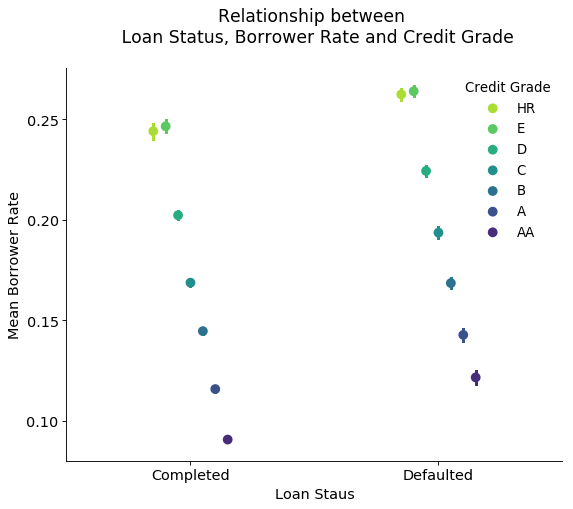

In [12]:
# Create a pointplot to present the relationship between 'LoanStatus', 'CreditGrade' and 'BorrowerRate'.
plt.figure(figsize=(8, 6.5), dpi=80)
 
ax = sb.pointplot(data = df_sub, x= 'LoanStatus', y= 'BorrowerRate', hue= 'CreditGrade', linestyles="", dodge = 0.3, palette="viridis_r");

# Set figure title, y= 1.05 adds a little space between the title and the chart.
plt.title('Relationship between \n Loan Status, Borrower Rate and Credit Grade', fontsize= 15.5, y= 1.05)

# Only kept the bottom & left axes line. 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Define the x & y ticks/labels
tick_pos = [0.10, 0.15, 0.20, 0.25]
tick_label = ['{:0.2f}'.format(x) for x in tick_pos]
plt.xticks(fontsize= 13)
plt.xlabel('Loan Staus', fontsize= 13)
plt.yticks(tick_pos,tick_label, fontsize= 13)
plt.ylabel('Mean Borrower Rate', fontsize= 13)
leg = ax.legend(frameon=False)
leg.set_title('Credit Grade',prop={'size':12});

## Effects of Loan Status,  Prosper Rating on Borrower Rate

Similar to the previous plot, lower Prosper Rating 'HR' and 'E' loans have the highest Mean Borrower Rate. <br> 
And as Prosper Rating increases in quality (from 'HR' to 'AA'), the Mean Borrower Rate became lower. <br>
Very interestingly, Defaulted loans also tend to have higher Mean Borrower Rate in every Prosper Rating category compared to the completed loans (except for 'HR' rating loans). 

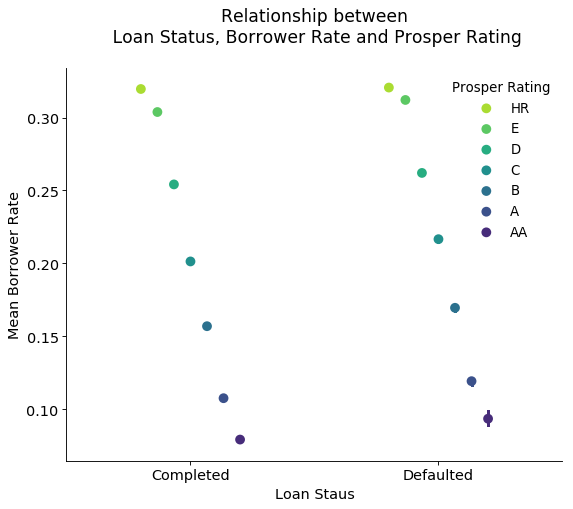

In [13]:
# Create a pointplot to present the relationship between 'LoanStatus', 'ProsperRating (Alpha)' and 'OriginalLoanAmount'.
plt.figure(figsize=(8, 6.5), dpi=80)
 
ax = sb.pointplot(data = df_sub, x= 'LoanStatus', y= 'BorrowerRate', hue= 'ProsperRating (Alpha)', linestyles="", dodge = 0.4, palette="viridis_r");

# Set figure title, y= 1.05 adds a little space between the title and the chart.
plt.title('Relationship between\n Loan Status, Borrower Rate and Prosper Rating', fontsize= 15.5, y= 1.05)

# Only kept the bottom & left axes line. 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Define the x & y ticks/labels
plt.xticks(fontsize= 13)
plt.xlabel('Loan Staus', fontsize= 13)
plt.yticks(fontsize= 13)
plt.ylabel('Mean Borrower Rate', fontsize= 13)
leg = ax.legend(frameon=False)
leg.set_title('Prosper Rating',prop={'size':12});